In [ ]:
!git clone https://github.com/BeastOrchestra/TFT_TGN.git
%cd TFT_TGN

# # Install dependencies directly with pip
# # !pip install pytorch-forecasting pandas numpy torch pytorch-lightning
# !pip install pandas numpy==1.24.0 torch==2.0.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install pytorch-forecasting==1.0.0
!pip install pytorch-forecasting pytorch-lightning
!pip install boto3

fatal: destination path 'tft_v0' already exists and is not an empty directory.
/home/ubuntu/tft_v0
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Download Data from S3

In [ ]:
import boto3
import os
from pathlib import Path

def download_from_s3(bucket_name, s3_folder, local_dir):
    s3_client = boto3.client('s3')
    paginator = s3_client.get_paginator('list_objects_v2')
    
    # Ensure the local directory exists
    local_dir = Path(local_dir)
    local_dir.mkdir(parents=True, exist_ok=True)

    for page in paginator.paginate(Bucket=bucket_name, Prefix=s3_folder):
        if 'Contents' in page:
            for obj in page['Contents']:
                s3_key = obj['Key']
                rel_path = s3_key[len(s3_folder):].lstrip("/")  # Remove folder prefix
                local_path = local_dir / rel_path
                
                # Ensure parent directories exist
                local_path.parent.mkdir(parents=True, exist_ok=True)
                
                # print(f"Downloading {s3_key} to {local_path}...")
                s3_client.download_file(bucket_name, s3_key, str(local_path))
    print('Complete Downloading Data')

# Example Usage
download_from_s3('arj-ibdata', 'data/', './data')
# All files for training and predicting should now be local

## Learning Rate Finder

In [3]:
import os
import torch
import pandas as pd

from torch.utils.data import DataLoader
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.models import TemporalFusionTransformer, Baseline
from pytorch_forecasting.metrics import MAE, MultiLoss, QuantileLoss
from pytorch_forecasting.data.encoders import MultiNormalizer, TorchNormalizer

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from lightning.pytorch.tuner import Tuner

# -----------------------------
# 1. Accelerator/Device Setup
# -----------------------------
if torch.cuda.is_available():
    accelerator = "cuda"
else:
    accelerator = "cpu"
DEVICE = accelerator  # Use this for Trainer and .to()

torch.set_float32_matmul_precision("medium")

# -----------------------------
# 2. Data Loading Function
# -----------------------------
def load_data(folder):
    all_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.csv')]
    dfs = []
    for file in all_files:
        # df = pd.read_csv(file, index_col=0)  # When There is no Date index
        df = pd.read_csv(file)
        # df=df.reset_index(drop=True)
        df=df.drop('date',axis=1) # Drops 'date' column
        df["time_idx"] = range(len(df))
        df["group"] = os.path.basename(file).split('.')[0]
        df["group"] = df["group"].astype(str)
        df.rename(columns={"Close": "target_1", "vclose": "target_2"}, inplace=True)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# -----------------------------
# 3. Load Datasets
# -----------------------------
train_data_folder = "data/train"
test_data_folder  = "data/test"
oos_data_folder   = "data/oos"

train_df = load_data(train_data_folder)
test_df  = load_data(test_data_folder)
oos_df   = load_data(oos_data_folder)

# -----------------------------
# 4. Multi-Target Dataset
# -----------------------------
training = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target=["target_1", "target_2"],
    group_ids=["group"],
    max_encoder_length=90,
    max_prediction_length=5,
    static_categoricals=["group"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=[
        c for c in train_df.columns if c not in ["group", "time_idx"]#, "target_1", "target_2"]
    ],
    target_normalizer=MultiNormalizer([
        TorchNormalizer(method="identity"),
        TorchNormalizer(method="identity")
    ])
)

validation = TimeSeriesDataSet.from_dataset(training, test_df)
oos = TimeSeriesDataSet.from_dataset(training, oos_df)

# -----------------------------
# 5. DataLoaders
# -----------------------------
train_dataloader = training.to_dataloader(
    train=True, batch_size=32, shuffle=True, num_workers=16, pin_memory=False
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=32, shuffle=False, num_workers=16, pin_memory=False
)
oos_dataloader = oos.to_dataloader(
    train=False, batch_size=64, shuffle=False, num_workers=16, pin_memory=False
)

import torch.nn as nn

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=3e-05,
    lstm_layers=2,
    hidden_size=256,
    attention_head_size=4,
    dropout=0.35,
    hidden_continuous_size=256,
    output_size=[1, 1],  # single output per target for MSE
    loss=MultiLoss([
        nn.MSELoss(),
        nn.MSELoss()
    ]),
    log_interval=200,
    reduce_on_plateau_patience=5,
).to(DEVICE)


print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

# -----------------------------
# 7. LightningModule Wrapper
# -----------------------------
class TFTLightningModule(LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model
        # Save the learning rate in hparams for LR finder purposes
        self.save_hyperparameters({'learning_rate': tft_model.hparams.learning_rate})
        
    def forward(self, x):
        return self.tft_model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        pred = out["prediction"]
        loss = self.tft_model.loss(pred, y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        pred = out["prediction"]
        loss = self.tft_model.loss(pred, y)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return self.tft_model.configure_optimizers()

tft_module = TFTLightningModule(tft).to(DEVICE)

# -----------------------------
# 8. Learning Rate Finder
# -----------------------------
pl.seed_everything(42)
# IMPORTANT: Create an LR finder trainer with an empty callbacks list.
lr_finder_trainer = Trainer(
    max_epochs=1,
    accelerator=accelerator,
    devices=1,
    precision=32,
    callbacks=[],  # ensure no LR finder callback is pre-configured
)

tuner = Tuner(lr_finder_trainer)
try:
    lr_find_result = tuner.lr_find(
        tft_module,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
        max_lr=1e-2,
        min_lr=5e-7,
        num_training=200,  # specify training steps to run
    )
except Exception as e:
    print("LR finder finished with an exception (expected):", e)
    # Try to get a result without update_attr if necessary:
    lr_find_result = tuner.lr_find(
        tft_module,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
        max_lr=1e-2,
        min_lr=5e-7,
        num_training=200,
        update_attr=False,
    )

suggested_lr = lr_find_result.suggestion()
print(f"Suggested learning rate: {suggested_lr:.2e}")



/home/ubuntu/.local/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/home/ubuntu/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/ubuntu/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 31338.8k


2025-03-01 00:01:05.593318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740787265.601252   19646 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740787265.604737   19646 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
`Trainer.fit` stopped: `max_steps=200` reached.00 [00:33<00:00,  6.22it/s]
Finding best initial lr: 100%|██████████| 200/200 [00:33<00:00,

LR finder finished with an exception (expected): 


ValueError: Trainer is already configured with a `LearningRateFinder` callback.Please remove it if you want to use the Tuner.

In [ ]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import MultiLoss, QuantileLoss, MAE
from pytorch_forecasting.data.encoders import MultiNormalizer, TorchNormalizer

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

# -----------------------------
# 1. Device Setup
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_float32_matmul_precision("medium")  # For NVIDIA Tensor Cores
print("Using device:", DEVICE)

# -----------------------------
# 2. Data Loading
# -----------------------------
def load_data(folder):
    all_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.csv')]
    dfs = []
    for file in all_files:
        # df = pd.read_csv(file, index_col=0)  # When There is no Date index
        df = pd.read_csv(file)
        # df=df.reset_index(drop=True)
        df=df.drop('date',axis=1) # Drops 'date' column
        df["time_idx"] = range(len(df))
        df["group"] = os.path.basename(file).split('.')[0]
        df["group"] = df["group"].astype(str)
        # rename 'Close' -> target_1, 'vclose' -> target_2
        df.rename(columns={"Close":"target_1","vclose":"target_2"}, inplace=True)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

train_data_folder = "data/train"
test_data_folder  = "data/test"
oos_data_folder   = "data/oos"

train_df = load_data(train_data_folder)
test_df  = load_data(test_data_folder)
oos_df   = load_data(oos_data_folder)

# -----------------------------
# 3. Multi-Target Dataset
# -----------------------------
training = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target=["target_1", "target_2"],
    group_ids=["group"],
    max_encoder_length=90,
    max_prediction_length=5,
    static_categoricals=["group"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=[
        c for c in train_df.columns if c not in ["group","time_idx"]#,"target_1","target_2"]
    ],
    target_normalizer=MultiNormalizer([
        TorchNormalizer(method="identity"),  # target_1
        TorchNormalizer(method="identity")   # target_2
    ])
)

# validation & OOS sets with predict_mode=False -> keep target data
validation = TimeSeriesDataSet.from_dataset(training, test_df, predict_mode=False)
oos        = TimeSeriesDataSet.from_dataset(training, oos_df,  predict_mode=False)

# -----------------------------
# 4. DataLoaders
# -----------------------------
train_dataloader = training.to_dataloader(
    train=True, batch_size=32, shuffle=True, num_workers=16, pin_memory=False
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=32, shuffle=False, num_workers=16, pin_memory=False
)
oos_dataloader = oos.to_dataloader(
    train=False, batch_size=16, shuffle=False, num_workers=16, pin_memory=False
)

# -----------------------------
# 5. Define Multi-Target TFT Model w/ Quantile Loss
# -----------------------------
import torch.nn as nn

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=2.320756917667678e-06,
    lstm_layers=2,
    hidden_size=256,
    attention_head_size=4,
    dropout=0.35,
    hidden_continuous_size=256,
    output_size=[1, 1],  # single output per target for MSE
    loss=MultiLoss([
        nn.MSELoss(),
        nn.MSELoss()
    ]),
    log_interval=500,
    reduce_on_plateau_patience=5,
).to(DEVICE)

print(f"Number of params in network: {tft.size() / 1e3:.1f}k")

# -----------------------------
# 6. LightningModule
# -----------------------------
class TFTLightningModule(LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model

    def forward(self, x):
        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        # 'y' is a tuple: ([target0_tensor, target1_tensor], None)
        out = self(x)
        pred = out["prediction"]  # list: 0 => target0, 1 => target1
        loss = self.tft_model.loss(pred, y)  # automatically handles multi-target
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        pred = out["prediction"]
        loss = self.tft_model.loss(pred, y)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return self.tft_model.configure_optimizers()

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        # If the batch is a (x, y) tuple, we only pass x to the model
        if isinstance(batch, (tuple, list)):
            x = batch[0]
        else:
            x = batch
        return self(x)

tft_module = TFTLightningModule(tft).to(DEVICE)

# Optional: training setup
early_stop_callback = EarlyStopping(monitor="val_loss", patience=7, mode="min")
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",
    filename="my-tft-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    monitor="val_loss",
    mode="min"
)

trainer = Trainer(
    max_epochs=45,   # set higher for real training
    accelerator="gpu" if DEVICE == "cuda" else "cpu",
    devices=1,
    precision=32,
    logger=CSVLogger("logs", name="tft_multi_target_quantile"),
    callbacks=[early_stop_callback, checkpoint_callback],
    log_every_n_steps=500,  # Adjust based on batch size
    enable_progress_bar=False,
)

# -----------------------------
# 7. (Un)comment to Train or Load
# -----------------------------
trainer.fit(tft_module, train_dataloader, val_dataloader)
# best_ckpt_path = "checkpoints/my-tft-epoch=XX-val_loss=YY.ckpt"
# tft_module = TFTLightningModule.load_from_checkpoint(best_ckpt_path, tft_model=tft).to(DEVICE)
# tft_module.eval()

# -----------------------------
# 8. Helper: Recursively move batch to device
# -----------------------------
def move_to_device(batch_x, device):
    """Ensure all Tensors in batch_x are on the same device."""
    if isinstance(batch_x, torch.Tensor):
        return batch_x.to(device)
    elif isinstance(batch_x, dict):
        return {k: move_to_device(v, device) for k, v in batch_x.items()}
    elif isinstance(batch_x, list):
        return [move_to_device(item, device) for item in batch_x]
    else:
        return batch_x



Using device: cuda


/home/ubuntu/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/ubuntu/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/.local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/ubuntu/tft_v0/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params | Mode 
--------------------------------------------

Number of params in network: 31338.8k


/home/ubuntu/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 20. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

## Save a model

In [ ]:
torch.save(tft_module.state_dict(), "./models/feb28_model.pth")

In [ ]:
# OOS Predictions

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import torch
# import os
# import numpy as np
# from pytorch_forecasting.metrics import MAE

# def move_to_device(batch_x, device):
#     """Ensure all Tensors in batch_x are on the same device."""
#     if isinstance(batch_x, torch.Tensor):
#         return batch_x.to(device)
#     elif isinstance(batch_x, dict):
#         return {k: move_to_device(v, device) for k, v in batch_x.items()}
#     elif isinstance(batch_x, list):
#         return [move_to_device(item, device) for item in batch_x]
#     else:
#         return batch_x

# # Define the stock symbol (you can replace this or loop through a list of symbols)
# stock_symbols = 'snex'  # Add more symbols here if needed
# stock_symbols = [stock_symbols.upper()]
# # Load TixSigMu.csv data
# mu_sig_df = pd.read_csv('./data/TixMuSig.csv')

# import torch

# # Set device
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print("Using device:", DEVICE)

# # Later when creating your model:
# tft_module = TFTLightningModule(tft).to(DEVICE)

# # # And when processing data:
# # x = move_to_device(x, DEVICE)


# # Function to process a single stock symbol
# def plot_predictions_for_symbol(stock_symbol):
#     # Load the dataframes
#     # train_data_folder = "data/train"
#     # test_data_folder  = "data/test"
#     oos_data_folder   = "data/oos"

#     # train_df = load_data(train_data_folder)
#     # test_df  = load_data(test_data_folder)
#     oos_df   = load_data(oos_data_folder)

#     # Filter the data for the specific stock
#     stock_oos_df = oos_df[oos_df["group"] == stock_symbol]

#     # Extracting raw data from 'target_1' (price) and 'target_2' (volatility) from the historical data (scaled)
#     historical_price = stock_oos_df['target_1'].values
#     mu_p = mu_sig_df.loc[mu_sig_df['ticker'] == stock_symbol, 'closemu'].values[0]
#     sig_p = mu_sig_df.loc[mu_sig_df['ticker'] == stock_symbol, 'closesig'].values[0]
#     historical_volatility = stock_oos_df['target_2'].values
#     mu_v = mu_sig_df.loc[mu_sig_df['ticker'] == stock_symbol, 'volmu'].values[0]
#     sig_v = mu_sig_df.loc[mu_sig_df['ticker'] == stock_symbol, 'volsig'].values[0]


#     # Descale the historical data for price and volatility
#     historical_price_descaled = historical_price * sig_p + mu_p
#     historical_volatility_descaled = historical_volatility * sig_v + mu_v

#     # Select only the last 65 periods for plotting
#     historical_price_last_65 = historical_price_descaled[-65:]
#     historical_volatility_last_65 = historical_volatility_descaled[-65:]

#     # Make predictions for price and volatility (using predict_mode=True)
#     eq_dataset = TimeSeriesDataSet.from_dataset(training, stock_oos_df, predict_mode=True)
#     eq_dataloader = eq_dataset.to_dataloader(
#         train=False,
#         batch_size=len(eq_dataset),  # All samples in one batch
#         shuffle=False,
#         num_workers=0,  # Use 0 workers to avoid multiprocessing issues
#         pin_memory=False
#     )

#     # Predict on the stock OOS data
#     with torch.no_grad():
#         for batch in eq_dataloader:
#             x, y_tuple = batch
#             y_list, _ = y_tuple
#             actual_target0 = y_list[0]  # Target_0 actual values (price)

#             # If x is a dictionary, inspect it
#             if isinstance(x, dict):
#                 encoder_cont = x.get('encoder_cont', None)  # Get the continuous features if available
#                 # print(f"Shape of encoder_cont: {encoder_cont.shape}")  # Print the shape of 'encoder_cont'
            
#             # Move input data to device (GPU or CPU)
#             x = move_to_device(x, DEVICE)

#             # Make predictions
#             out = tft_module(x)
#             preds = out["prediction"]
            
#             median_pred_target0 = preds[0][:, :, 0].cpu()
#             median_pred_target1 = preds[1][:, :, 0].cpu()

    
#     # Extract predictions from the batch
#     price_preds = median_pred_target0
#     vol_preds = median_pred_target1

#     price_preds_descaled = price_preds*sig_p + mu_p
#     vol_preds_descaled = vol_preds*sig_v + mu_v

#     # Flatten the predictions to ensure the correct shape for plotting
#     price_preds_flat = price_preds_descaled.flatten()  # Flatten the price predictions
#     vol_preds_flat = vol_preds_descaled.flatten()  # Flatten the volatility predictions

#     # Get the range for plotting (next 5 periods after historical data)
#     forecast_start_idx = len(historical_price_last_65)  # First index after the last 65 periods
#     forecast_end_idx = forecast_start_idx + 5  # 5 prediction periods

#     # Plot the actual price, actual volatility, and predicted values (descaled)
#     fig, ax = plt.subplots(2, 1, figsize=(10, 12))

#     # Plot actual price and predicted price
#     ax[0].plot(range(len(historical_price_last_65)), historical_price_last_65, label=f'{stock_symbol} Actual Price (target_1)', color='black')
#     ax[0].plot(range(forecast_start_idx, forecast_end_idx), price_preds_flat, 'r--', label=f'{stock_symbol} Predicted Price')
#     ax[0].set_title(f"{stock_symbol} - Price Predictions vs. Actuals")
#     ax[0].set_xlabel("Time Steps")
#     ax[0].set_ylabel("Price")
#     ax[0].legend()
#     ax[0].grid()

#     # Plot actual volatility and predicted volatility
#     ax[1].plot(range(len(historical_volatility_last_65)), historical_volatility_last_65, label=f'{stock_symbol} Actual Volatility (target_2)', color='black')
#     ax[1].plot(range(forecast_start_idx, forecast_end_idx), vol_preds_flat, 'r--', label=f'{stock_symbol} Predicted Volatility')
#     ax[1].set_title(f"{stock_symbol} - Volatility Predictions vs. Actuals")
#     ax[1].set_xlabel("Time Steps")
#     ax[1].set_ylabel("Volatility")
#     ax[1].legend()
#     ax[1].grid()

#     # Adjust layout to prevent overlap
#     plt.tight_layout()

#     # Show the plot
#     plt.show()

# # Loop over all stock symbols
# for stock_symbol in stock_symbols:
#     plot_predictions_for_symbol(stock_symbol)


# # aapl_oos_df = oos_df[oos_df["group"] == stock_symbol]
# stock_oos_df = oos_df[oos_df["group"] == stock_symbol]
# print(f"Number of OOS records for {stock_symbol}: {len(stock_oos_df)}")

# # Create a dataset for that specific stock using the training dataset parameters.
# eq_dataset = TimeSeriesDataSet.from_dataset(training, stock_oos_df, predict_mode=False)

# # To obtain a single batch containing all data for, set batch_size to the size of the dataset.
# eq_dataloader_backtest = eq_dataset.to_dataloader(
#     train=False,
#     batch_size=len(eq_dataset),  # all samples in one batch
#     shuffle=False,
#     num_workers=0,  # use 0 workers to avoid multiprocessing issues
#     pin_memory=False
# )

# # Predict on the OOS data.
# eq_preds = []
# eq_actuals = []

# with torch.no_grad():
#     for batch in eq_dataloader_backtest:
#         x, y_tuple = batch
#         y_list, _ = y_tuple
#         actual_target0 = y_list[1]  # target_1 actual values
#         x = move_to_device(x, DEVICE)
#         out = tft_module(x)
#         preds = out["prediction"]
#         median_pred_target0 = preds[1][:, :, 0].cpu()  # median quantile for target_1
#         eq_preds.append(median_pred_target0)
#         eq_actuals.append(actual_target0)

# # Since we have only one batch, take the first element.
# eq_pred_tensor = eq_preds[-1]
# eq_actual_tensor = eq_actuals[-1]

# # -----------------------------
# # Compute a Metric (e.g., MAE) on the Specific Stock Data
# # -----------------------------
# mae_metric = MAE()
# eq_mae = mae_metric(eq_pred_tensor, eq_actual_tensor)
# print(f"MAE for {stock_symbol} (target_0, median): {eq_mae.item():.4f}")


Using device: cuda


NameError: name 'x' is not defined

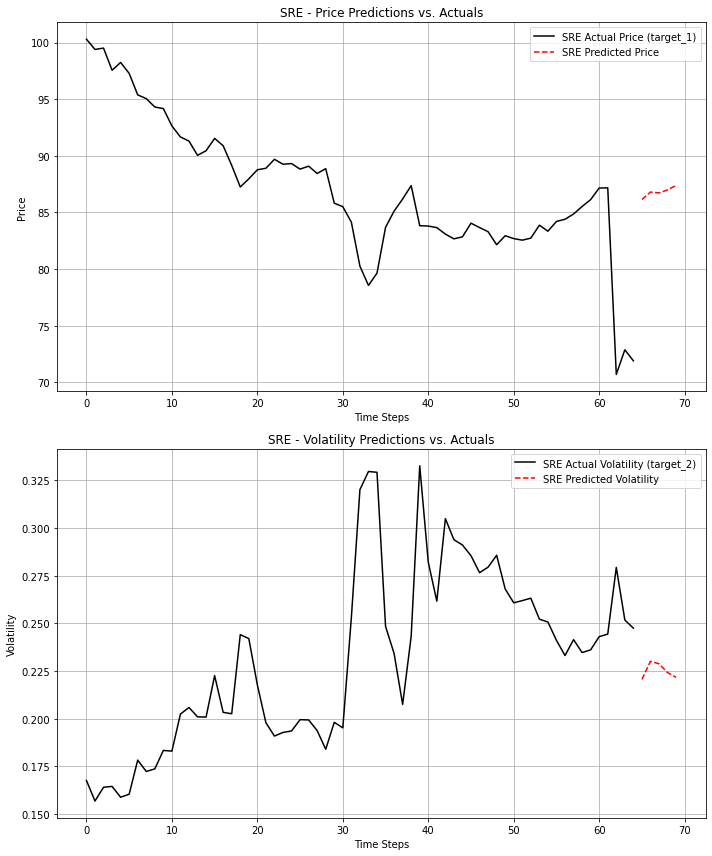

Number of OOS records for SRE: 252
MAE for SRE (target_0, median): 0.8484


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from pytorch_forecasting.metrics import MAE
device= "gpu"
def move_to_device(batch_x, device):
    """Ensure all Tensors in batch_x are on the same device."""
    if isinstance(batch_x, torch.Tensor):
        return batch_x.to(device)
    elif isinstance(batch_x, dict):
        return {k: move_to_device(v, device) for k, v in batch_x.items()}
    elif isinstance(batch_x, list):
        return [move_to_device(item, device) for item in batch_x]
    else:
        return batch_x

# Define the stock symbol (you can replace this or loop through a list of symbols)
stock_symbols = 'sre'  # Add more symbols here if needed
stock_symbols = [stock_symbols.upper()]
# Load TixSigMu.csv data
mu_sig_df = pd.read_csv('./data/TixMuSig.csv')

# Function to process a single stock symbol
def plot_predictions_for_symbol(stock_symbol):
    # Load the dataframes
    # train_data_folder = "data/train"
    # test_data_folder  = "data/test"
    oos_data_folder   = "data/oos"

    # train_df = load_data(train_data_folder)
    # test_df  = load_data(test_data_folder)
    oos_df   = load_data(oos_data_folder)

    # Filter the data for the specific stock
    stock_oos_df = oos_df[oos_df["group"] == stock_symbol]

    # Extracting raw data from 'target_1' (price) and 'target_2' (volatility) from the historical data (scaled)
    historical_price = stock_oos_df['target_1'].values
    mu_p = mu_sig_df.loc[mu_sig_df['ticker'] == stock_symbol, 'closemu'].values[0]
    sig_p = mu_sig_df.loc[mu_sig_df['ticker'] == stock_symbol, 'closesig'].values[0]
    historical_volatility = stock_oos_df['target_2'].values
    mu_v = mu_sig_df.loc[mu_sig_df['ticker'] == stock_symbol, 'volmu'].values[0]
    sig_v = mu_sig_df.loc[mu_sig_df['ticker'] == stock_symbol, 'volsig'].values[0]


    # Descale the historical data for price and volatility
    historical_price_descaled = historical_price * sig_p + mu_p
    historical_volatility_descaled = historical_volatility * sig_v + mu_v

    # Select only the last 65 periods for plotting
    historical_price_last_65 = historical_price_descaled[-65:]
    historical_volatility_last_65 = historical_volatility_descaled[-65:]

    # Make predictions for price and volatility (using predict_mode=True)
    eq_dataset = TimeSeriesDataSet.from_dataset(training, stock_oos_df, predict_mode=True)
    eq_dataloader = eq_dataset.to_dataloader(
        train=False,
        batch_size=len(eq_dataset),  # All samples in one batch
        shuffle=False,
        num_workers=0,  # Use 0 workers to avoid multiprocessing issues
        pin_memory=False
    )

    # Predict on the stock OOS data
    with torch.no_grad():
        for batch in eq_dataloader:
            x, y_tuple = batch
            y_list, _ = y_tuple
            actual_target0 = y_list[0]  # Target_0 actual values (price)

            # If x is a dictionary, inspect it
            if isinstance(x, dict):
                encoder_cont = x.get('encoder_cont', None)  # Get the continuous features if available
                # print(f"Shape of encoder_cont: {encoder_cont.shape}")  # Print the shape of 'encoder_cont'
            
            # Move input data to device (GPU or CPU)
            x = move_to_device(x, DEVICE)

            # Make predictions
            out = tft_module(x)
            preds = out["prediction"]
            
            # Extract the price and volatility predictions
            median_pred_target0 = preds[0][:, :, 0].cpu()  # Median quantile for target_0 (price)
            median_pred_target1 = preds[1][:, :, 0].cpu()  # Median quantile for target_1 (volatility)
    
    # Extract predictions from the batch
    price_preds = median_pred_target0
    vol_preds = median_pred_target1

    price_preds_descaled = price_preds*sig_p + mu_p
    vol_preds_descaled = vol_preds*sig_v + mu_v

    # Flatten the predictions to ensure the correct shape for plotting
    price_preds_flat = price_preds_descaled.flatten()  # Flatten the price predictions
    vol_preds_flat = vol_preds_descaled.flatten()  # Flatten the volatility predictions

    # Get the range for plotting (next 5 periods after historical data)
    forecast_start_idx = len(historical_price_last_65)  # First index after the last 65 periods
    forecast_end_idx = forecast_start_idx + 5  # 5 prediction periods

    # Plot the actual price, actual volatility, and predicted values (descaled)
    fig, ax = plt.subplots(2, 1, figsize=(10, 12))

    # Plot actual price and predicted price
    ax[0].plot(range(len(historical_price_last_65)), historical_price_last_65, label=f'{stock_symbol} Actual Price (target_1)', color='black')
    ax[0].plot(range(forecast_start_idx, forecast_end_idx), price_preds_flat, 'r--', label=f'{stock_symbol} Predicted Price')
    ax[0].set_title(f"{stock_symbol} - Price Predictions vs. Actuals")
    ax[0].set_xlabel("Time Steps")
    ax[0].set_ylabel("Price")
    ax[0].legend()
    ax[0].grid()

    # Plot actual volatility and predicted volatility
    ax[1].plot(range(len(historical_volatility_last_65)), historical_volatility_last_65, label=f'{stock_symbol} Actual Volatility (target_2)', color='black')
    ax[1].plot(range(forecast_start_idx, forecast_end_idx), vol_preds_flat, 'r--', label=f'{stock_symbol} Predicted Volatility')
    ax[1].set_title(f"{stock_symbol} - Volatility Predictions vs. Actuals")
    ax[1].set_xlabel("Time Steps")
    ax[1].set_ylabel("Volatility")
    ax[1].legend()
    ax[1].grid()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

# Loop over all stock symbols
for stock_symbol in stock_symbols:
    plot_predictions_for_symbol(stock_symbol)


# aapl_oos_df = oos_df[oos_df["group"] == stock_symbol]
stock_oos_df = oos_df[oos_df["group"] == stock_symbol]
print(f"Number of OOS records for {stock_symbol}: {len(stock_oos_df)}")

# Create a dataset for that specific stock using the training dataset parameters.
eq_dataset = TimeSeriesDataSet.from_dataset(training, stock_oos_df, predict_mode=True)

# To obtain a single batch containing all data for, set batch_size to the size of the dataset.
eq_dataloader_backtest = eq_dataset.to_dataloader(
    train=False,
    batch_size=len(eq_dataset),  # all samples in one batch
    shuffle=False,
    num_workers=0,  # use 0 workers to avoid multiprocessing issues
    pin_memory=False
)

# Predict on the OOS data.
eq_preds = []
eq_actuals = []

with torch.no_grad():
    for batch in eq_dataloader_backtest:
        x, y_tuple = batch
        y_list, _ = y_tuple
        actual_target0 = y_list[1]  # target_1 actual values
        x = move_to_device(x, DEVICE)
        out = tft_module(x)
        preds = out["prediction"]
        median_pred_target0 = preds[1][:, :, 0].cpu()  # median quantile for target_1
        eq_preds.append(median_pred_target0)
        eq_actuals.append(actual_target0)

# Since we have only one batch, take the first element.
eq_pred_tensor = eq_preds[-1]
eq_actual_tensor = eq_actuals[-1]

# -----------------------------
# Compute a Metric (e.g., MAE) on the Specific Stock Data
# -----------------------------
mae_metric = MAE()
eq_mae = mae_metric(eq_pred_tensor, eq_actual_tensor)
print(f"MAE for {stock_symbol} (target_0, median): {eq_mae.item():.4f}")
